# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

('Loaded feature names:', 126)


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000L, 126L) (1124L, 126L)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

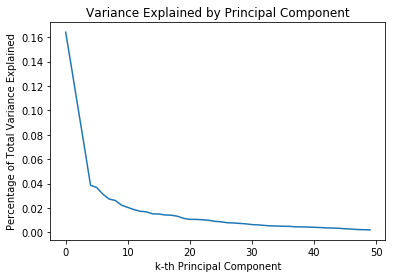

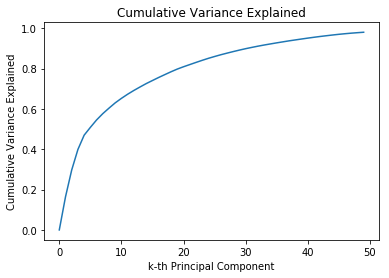

In [7]:
def P1():
    pca = PCA(n_components=50)
    pca.fit(train_data)
    cumulative_variance_explained = [sum(pca.explained_variance_ratio_[0:k]) for k in range(50)]
    
    # Variance By Principal Component
    plt.plot(pca.explained_variance_ratio_)
    plt.xlabel('k-th Principal Component')
    plt.ylabel('Percentage of Total Variance Explained')
    plt.title('Variance Explained by Principal Component')
    
    # Cumulative Variance
    plt.figure()
    plt.plot(cumulative_variance_explained)
    plt.xlabel('k-th Principal Component')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance Explained')
P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

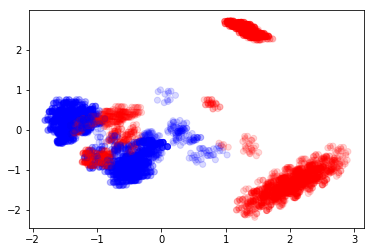

In [11]:
def P2():
    pca = PCA(n_components=2)
    reduced_train_data = pca.fit_transform(train_data)
    colors = np.where(train_labels==1, 'r', 'b')
    plt.scatter(reduced_train_data[:,0], reduced_train_data[:,1], c=colors, alpha=.15)

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

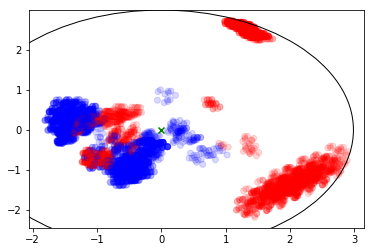

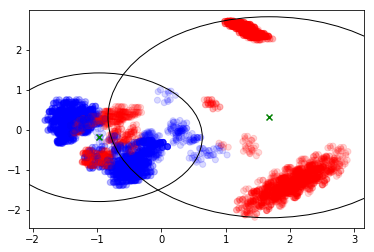

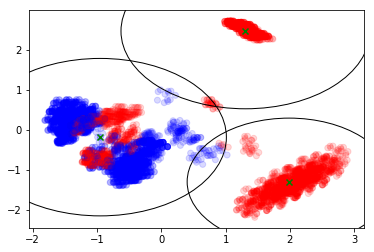

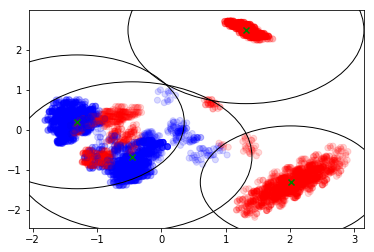

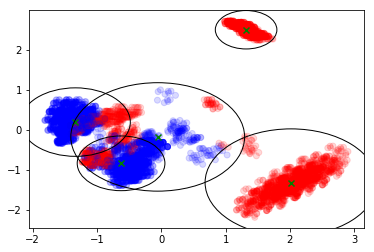

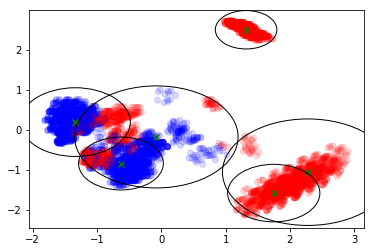

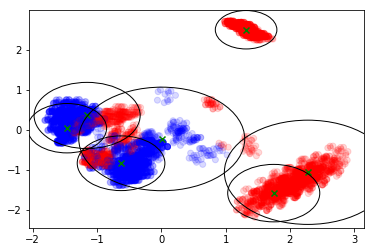

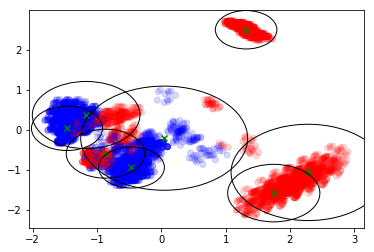

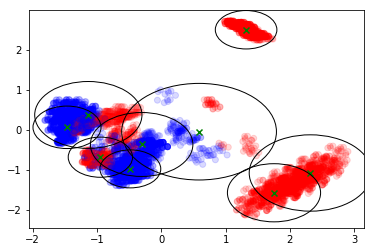

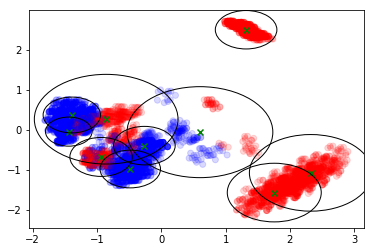

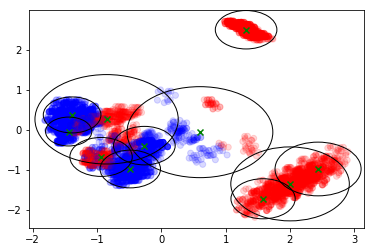

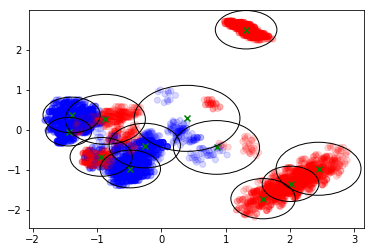

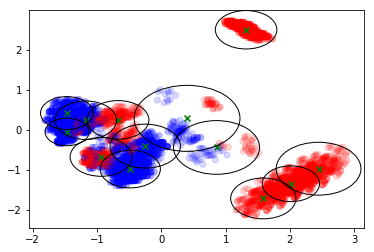

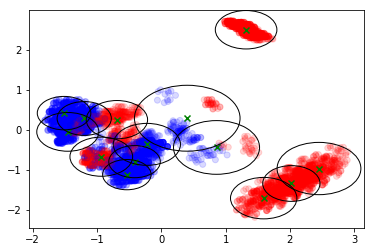

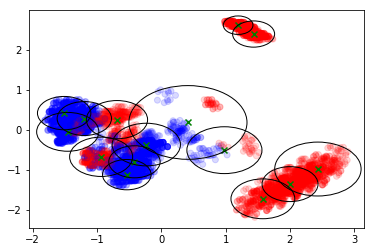

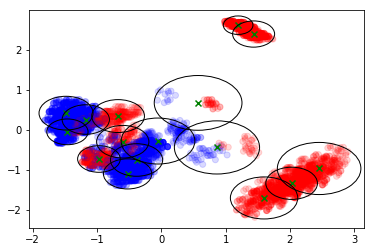

In [12]:
def P3():
    pca = PCA(n_components=2)
    reduced_train_data = pca.fit_transform(train_data)
    colors = np.where(train_labels==1, 'r', 'b')
    
    for clusters in range(1,17):
        km = KMeans(n_clusters=clusters)
        km.fit(reduced_train_data)
        plt.figure()
        
        # Plot base data
        plt.scatter(reduced_train_data[:,0], reduced_train_data[:,1], c=colors, alpha=.15)
        # Plot centroid
        plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker='x', color='g')
        
        # for each cluster, plot circle encompassing all points in cluster (i.e. through furthest point in cluster)
        for cluster in range(clusters):
            points = reduced_train_data[np.where(km.labels_==cluster)]
            max_dist = 0
            # for each point in the cluster
            for point in points:
                # calculate distance from centroid
                dist = np.linalg.norm(km.cluster_centers_[cluster] - point)
                # store furthest point and distance
                if dist > max_dist:
                    max_dist = dist
                    furthest_point = point
            # Plot circle
            fig = plt.gcf()
            ax = fig.gca()
            circle = plt.Circle(km.cluster_centers_[cluster], max_dist, color='k', fill=False)
            ax.add_artist(circle)
    
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

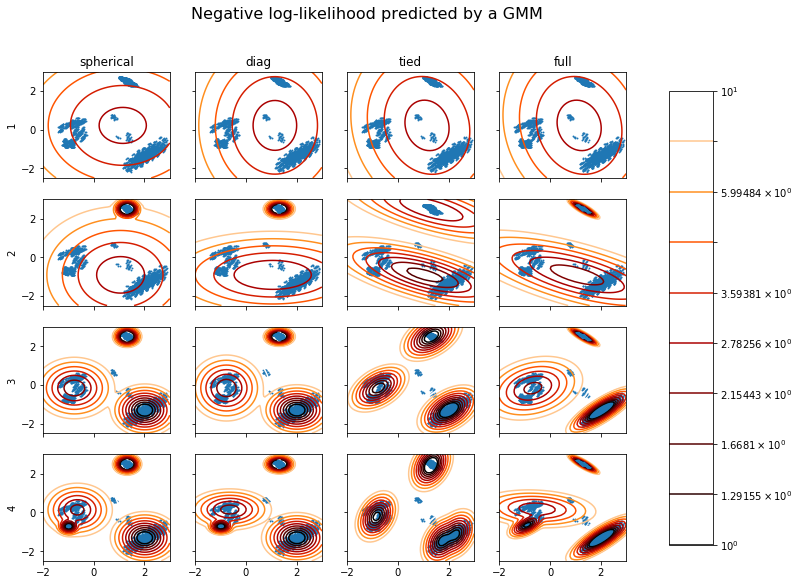

In [62]:
def P4():
    pca = PCA(n_components=2)
    reduced_train_data = pca.fit_transform(train_data)
    positive_train_data = reduced_train_data[train_labels==1]
    
    fig, axs = plt.subplots(4, 4, constrained_layout=True, squeeze=True, sharex=True, sharey=True, figsize=(12, 9))
    
    # iterate over hyperparameters
    for components in range(1,5):
        # j is column for formatting purposes
        j = -1
        for cov_type in ['spherical', 'diag', 'tied', 'full']:
            j += 1
            
            # fit model
            gm = GaussianMixture(n_components=components, covariance_type=cov_type)
            gm.fit(positive_train_data)
            
            # display predicted scores by the model as a contour plot
            x = np.linspace(-2., 3.)
            y = np.linspace(-2.5, 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm.score_samples(XX)
            Z = Z.reshape(X.shape)

            # Plot data
            CS = axs[components-1, j].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=10.0),
                             levels=np.logspace(0, 1, 10), cmap='gist_heat')
            axs[components-1, j].scatter(positive_train_data[:, 0], positive_train_data[:, 1], .8)

            # Format subplot
            if j == 0:
                axs[i, j].set_ylabel(str(components))
            if components == 1:
                axs[i, j].set_title(cov_type)
    
    # Format full axes
    fig.suptitle('Negative log-likelihood predicted by a GMM', fontsize=16)
    plt.axis('tight')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(CS, cax=cbar_ax)
    plt.show()

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [68]:
def P5():
    # Perform PCA and split positive/negative from training data
    pca = PCA(n_components=2)
    reduced_train_data = pca.fit_transform(train_data)
    positive_train_data = reduced_train_data[train_labels==1]
    negative_train_data = reduced_train_data[train_labels==0]
    reduced_test_data = pca.fit_transform(test_data)

    # Fit GMMs
    gm_pos = GaussianMixture(n_components=4, covariance_type='full', n_init=100)
    gm_pos.fit(positive_train_data)
    gm_neg = GaussianMixture(n_components=4, covariance_type='full', n_init=100)
    gm_neg.fit(negative_train_data)

    # Score test data based on each GMM
    positive_scores = gm_pos.score_samples(reduced_test_data)
    negative_scores = gm_neg.score_samples(reduced_test_data)

    # Evaluate accuracy
    positive_guesses = (positive_scores > negative_scores).astype(int)
    correct = np.sum((positive_guesses == test_labels).astype(int))
    accuracy = float(correct)/float(len(test_labels))
    print(accuracy)

P5()

0.508896797153


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

#### Let's start with some formulas based on the type of covariance matrix.

Each specification will have $n$ mean vectors where $n$ is the number of PCA components. It will also have a number of covariance parameters that is based on $n$ and the number of GMM componenets, which I will call $m$. The number of classes will be fixed at 2 (poisonous or not).

Full covariance (each component has its own general covariance matrix)

$[n + \frac{1}{2}n(n+1)]*m*2 \leq 50$

Tied covariance (all components share the same general covariance matrix)

$[n + \frac{1}{2}n(n+1)\frac{1}{m}]*m*2 \leq 50$

Diagonal covariance (each component has its own diagonal covariance matrix)

$(n + n)*m*2 \leq 50$

Spherical covariance (each component has its own single variance). 

$(n + 1)*m*2 \leq 50$

Since the solution space isn't that vast, I'll just check them all brute force, rather than experiment with a subset.

In [89]:
def full(n, m):
    comp = (n + n**2.0/2.0 + n/2.0) * m * 2.0
    return comp

def diag(n, m):
    comp = (n + n) * m * 2.0
    return comp

def tied(n, m):
    comp = (n*m + (n**2.0/2.0 + n/2.0)) * 2.0
    return comp

def spherical(n, m):
    comp = (n+1.0) * m * 2.0
    return comp
    
def P6():
    best_score = 0
    for func in [full, diag, tied, spherical]:
        n = 1.0
        m = 1.0
        while func(n, m) <= 50.0:
            # Perform PCA and split positive/negative from training data
            pca = PCA(n_components=int(n))
            reduced_train_data = pca.fit_transform(train_data)
            positive_train_data = reduced_train_data[train_labels==1]
            negative_train_data = reduced_train_data[train_labels==0]
            reduced_test_data = pca.fit_transform(test_data)
            
            while func(n, m) <= 50.0:
                # Fit GMMs
                gm_pos = GaussianMixture(n_components=int(m), covariance_type=func.__name__, n_init=100)
                gm_pos.fit(positive_train_data)
                gm_neg = GaussianMixture(n_components=int(m), covariance_type=func.__name__, n_init=100)
                gm_neg.fit(negative_train_data)

                # Score test data based on each GMM
                positive_scores = gm_pos.score_samples(reduced_test_data)
                negative_scores = gm_neg.score_samples(reduced_test_data)

                # Evaluate accuracy
                positive_guesses = (positive_scores > negative_scores).astype(int)
                correct = np.sum((positive_guesses == test_labels).astype(int))
                accuracy = float(correct)/float(len(test_labels))
                if accuracy > best_score:
                    best_score = accuracy
                    best_params = (func.__name__, n, m)
                m += 1.0
            m = 1.0
            n += 1.0
    print(best_params, best_score)
    
P6()

(('spherical', 3.0, 5.0), 0.9430604982206405)


My best result is with spherical covariance matrices, 3 PCA components, and 5 GMM components, and yields an accuracy of .94 when run with 100 initializations to reduce random error. It's interesting that spherical comes out ahead. Apparently the accurate modeling of a covariance matrix is not that crucial, which is reminiscent of how naive Bayes can get reasonable accuracy while ignoring covariances. The parameters are better spent on an appropriate number of principal components and Gaussian mixtures.